Bulk processing Sentinel products to PNG images

In [1]:
import geopandas as gpd
import folium
import os
from PIL import Image
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import matplotlib.pyplot as plt
import numpy as np
import os
#from geojson import Point
from geojson import Polygon
import geojson
import tempfile
import datetime as dt
from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio import plot
import rasterio.mask
import fiona
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from skimage import exposure
from pathlib import Path

 Sentinel2
--- S2A_MSIL1C_20210206T095201_N0209_R079_T33SVV_20210206T110416.SAFE
------ AUX_DATA
------ DATASTRIP
--------- DS_EPAE_20210206T110416_S20210206T095357
------------ QI_DATA
------ GRANULE
--------- L1C_T33SVV_A029391_20210206T095357
------------ AUX_DATA
------------ IMG_DATA
--------------- T33SVV_20210206T095201_B01.jp2
--------------- T33SVV_20210206T095201_B02.jp2
--------------- T33SVV_20210206T095201_B03.jp2
--------------- T33SVV_20210206T095201_B04.jp2
--------------- T33SVV_20210206T095201_B05.jp2
--------------- T33SVV_20210206T095201_B06.jp2
--------------- T33SVV_20210206T095201_B07.jp2
--------------- T33SVV_20210206T095201_B08.jp2
--------------- T33SVV_20210206T095201_B09.jp2
--------------- T33SVV_20210206T095201_B10.jp2
--------------- T33SVV_20210206T095201_B11.jp2
--------------- T33SVV_20210206T095201_B12.jp2
--------------- T33SVV_20210206T095201_B8A.jp2
--------------- T33SVV_20210206T095201_TCI.jp2
1
10980
10980
uint16
EPSG:32633
| 10.00, 0.00, 39996

C:\ProgramData\Anaconda3\envs\pixam\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


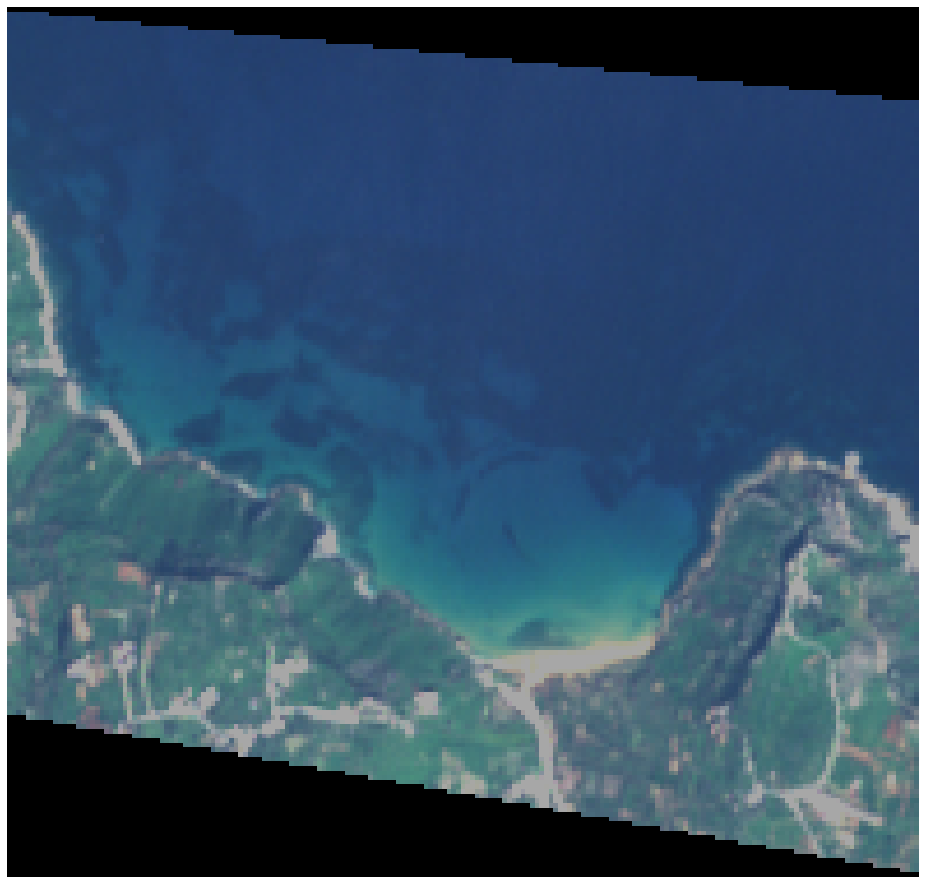

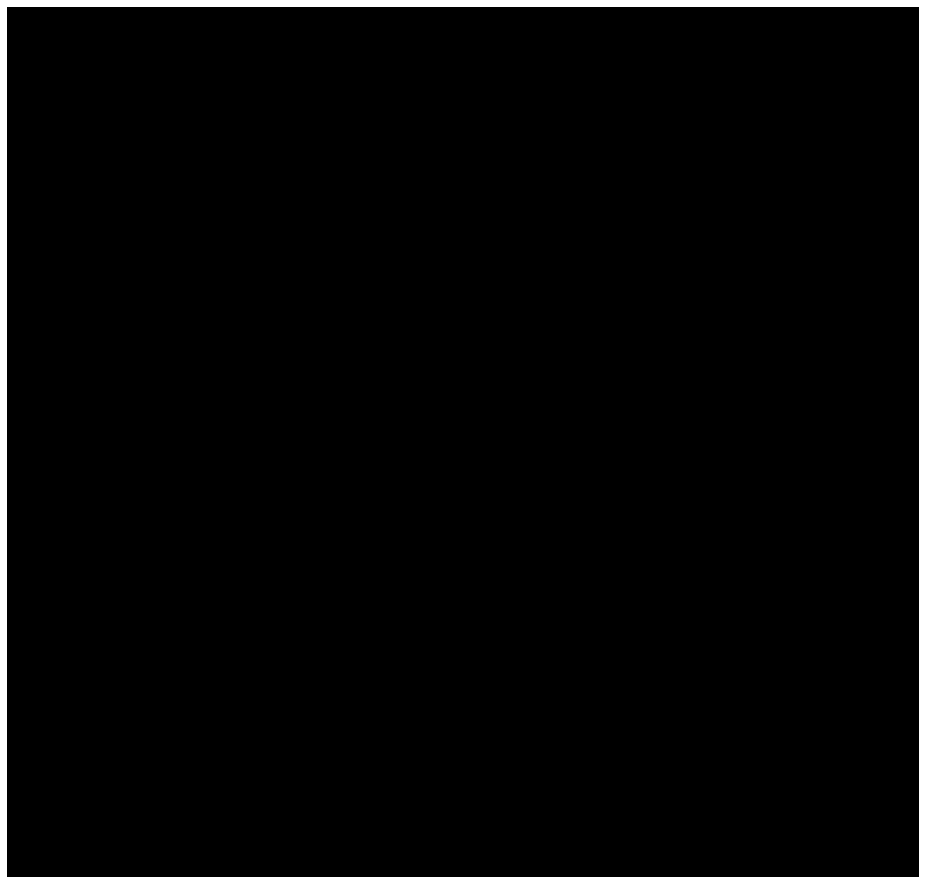

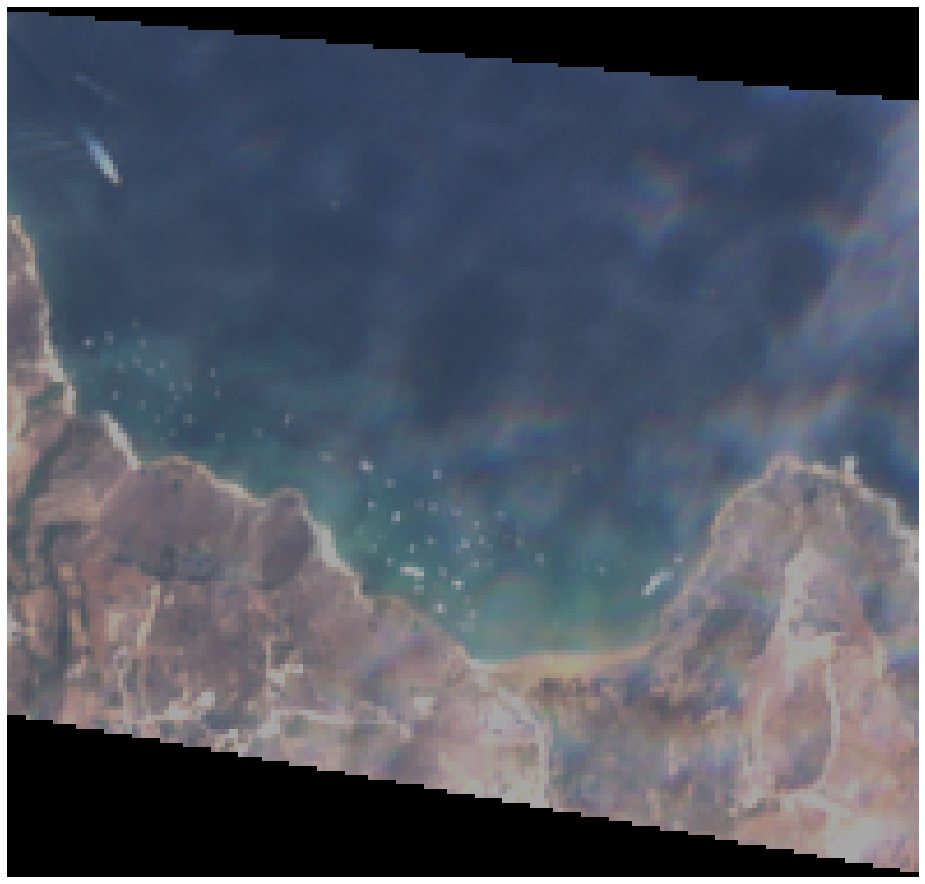

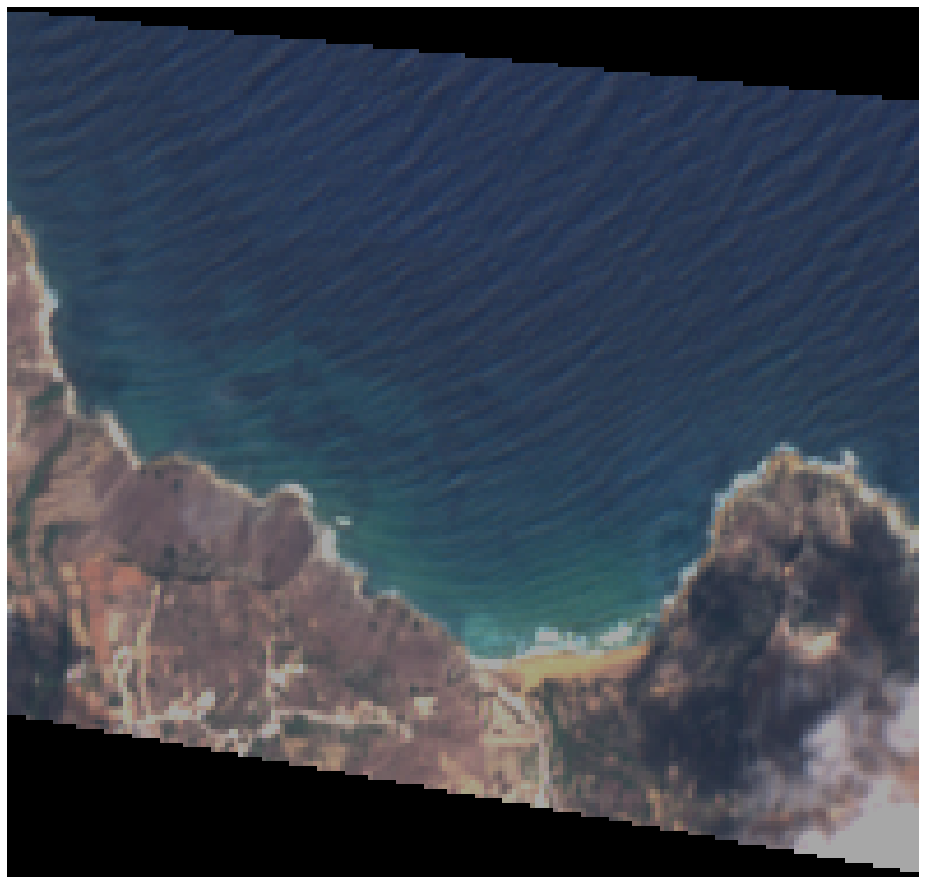

In [5]:
# Create a path to the exported folder
path = Path('../data/Sentinel2')
k=0
# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk("../data/Sentinel2"):
    path = root.split(os.sep)
    print((len(path) - 1) * '---', os.path.basename(root))

    if os.path.basename(root) == 'IMG_DATA':
        k+=1
        for file in files:
            print(len(path) * '---', file)

            if 'B02' in file: band2 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #blue
            if 'B03' in file: band3 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #green
            if 'B04' in file: band4 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #red
            #if 'B08' in file: band8 = rasterio.open(os.path.join(root,file), driver='JP2OpenJPEG') #nir

        if band2 is not None:
            #number of raster bands
            print(band2.count)
            #number of raster columns
            print(band2.width)
            #number of raster rows
            print(band2.height)

            #type of raster byte
            print(band2.dtypes[0])
            #raster sytem of reference
            print(band2.crs)
            #raster transform parameters
            print(band2.transform)

            #export true color image
            trueColor = rasterio.open('../Output/CACHE/SentinelTemp.tiff','w',driver='Gtiff',
                                     width=band4.width, height=band4.height,
                                     count=3,
                                     crs=band4.crs,
                                     transform=band2.transform,
                                     dtype=band2.dtypes[0]
                                     )
            trueColor.write(band2.read(1),1) #blue
            trueColor.write(band3.read(1),2) #green
            trueColor.write(band4.read(1),3) #red
            trueColor.close()

            # Mask area of study

            # Load polygon vector of Gozo to clip satellite image
            boundsdata = r'../data/ramla/ramla.geojson'
            region = gpd.read_file(boundsdata)
            region

            nReserve_proj = region.to_crs({'init': 'epsg:32633'})

            with rio.open("../Output/CACHE/SentinelTemp.tiff") as src:
                out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform,
                             "dtype": "uint16"})




            # Rescale the image (divide by 10000 to convert to [0:1] reflectance
            image = np.array(out_image[[2,1,0], :, :])
            p2, p98 = np.percentile(image, (2,98))
            image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

            rgb = np.array(image.transpose(1,2,0))

            #Plot and save image with Matplotlib
            fig = plt.figure(figsize=(20,16))
            ax=fig.add_subplot(1,1,1)
            plt.axis('off')
            plt.imshow(rgb)

            #Save scaled reflectance image
            # Call 'savefig' to save this plot to an image file
            file_to_save = 'Rendered_' + str(k).zfill(3) +'.png'
            plt.savefig(os.path.join('../Output/PROCESSED', file_to_save), bbox_inches='tight', transparent=True, pad_inches=0)
            plt.show()








Read images from a directory and construct video

In [3]:
# Creaating Video from Images using OpenCV-Python
import cv2
import numpy as np
import glob

img_array = []
for filename in glob.glob('../Output/PROCESSED/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'MJPG'), 1, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()


In [1]:
# Algorithm for blending multiple images using OpenCV

import glob
import numpy as np
import cv2

# Import all image files with the .jpg extension
files = glob.glob ('../Output/PROCESSED/*.png')
image_data = []
for my_file in files:
    this_image = cv2.imread(my_file, 1)
    image_data.append(this_image)

# Calculate blended image
dst = image_data[0]
for i in range(len(image_data)):
    if i == 0:
        pass
    else:
        alpha = 1.0/(i + 1)
        beta = 1.0 - alpha
        dst = cv2.addWeighted(image_data[i], alpha, dst, beta, 0.0)

# Save blended image
cv2.imwrite('../Output/PROCESSED/blended.png', dst)


True